<a href="https://colab.research.google.com/github/ugurcancakal/network_pytorch/blob/master/DNN_GPU_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Deep Neural Networks on a GPU with Pytorch

In [1]:
import torch
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [2]:
dataset = MNIST(root ='data/',
                download = True,
                transform = ToTensor())


In [3]:
img,label = dataset[0]
print(img.shape, label)

torch.Size([1, 28, 28]) 5


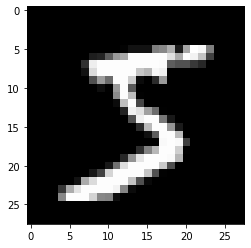

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img[0], cmap='gray')

In [5]:
def split_indices(n, val_pct):
  # Size of the dataset
  n_val = int(val_pct*n)
  # Random permutation from 0 to n-1
  idx = np.random.permutation(n)
  # Pick the first n values
  return idx[n_val:], idx[:n_val]

In [6]:
train_indices, val_indices = split_indices(len(dataset),val_pct = 0.2)

print(len(train_indices), len(val_indices))
print('Sample val indices: ', val_indices[:20])

48000 12000
Sample val indices:  [31650 27634 37250 54503 47251 32650 51054 19810 53850 24972 45491 57066
 14914 20384 39042  4584  6219 16541 26388  3771]


In [7]:
batch_size = 100

# Train Sampler
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                      batch_size,
                      sampler=train_sampler)
# Validation Sampler 
valid_sampler = SubsetRandomSampler(val_indices)
valid_dl = DataLoader(dataset,
                      batch_size,
                      sampler=valid_sampler)

# Model

To improve upon [logistic regression](https://jvn.io/aakashns/a1b40b04f5174a18bd05b17e3dffb0f0), we'll create a neural network with one **hidden layer**. Here's what this means:

* Instead of using a single `nn.Linear` object to transform a batch of inputs (pixel intensities) into a batch of outputs (class probabilities), we'll use two `nn.Linear` objects. Each of these is called a layer in the network. 

* The first layer (also known as the hidden layer) will transform the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`, where `hidden_size` is a preconfigured parameter (e.g. 32 or 64).

* The intermediate outputs are then passed into a non-linear *activation function*, which operates on individual elements of the output matrix.

* The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also knowns as the output layer), which transforms it into a matrix of size `batch_size x 10`, identical to the output of the logistic regression model.

Introducing a hidden layer and an activation function allows the model to learn more complex, multi-layered and non-linear relationships between the inputs and the targets. Here's what it looks like visually:

![](https://i.imgur.com/vDOGEkG.png)

The activation function we'll use here is called a **Rectified Linear Unit** or **ReLU**, and it has a really simple formula: `relu(x) = max(0,x)` i.e. if an element is negative, we replace it by 0, otherwise we leave it unchanged.

To define the model, we extend the `nn.Module` class, just as we did with logistic regression.

In [8]:
import torch.nn.functional as F
import torch.nn as nn

In [9]:
class MnistModel(nn.Module):
  '''Feedforward neural network with 1 hidden layer
  '''
  def __init__(self, in_size, hidden_size, out_size):
    super().__init__()
    # hidden layer
    self.linear1 = nn.Linear(in_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, out_size)
  
  def forward(self,xb):
    # Flatten the image tensors
    xb = xb.view(xb.size(0),-1)
    # Get intermediate outputs using hidden layer
    out = self.linear1(xb)
    # Apply activation function
    out = F.relu(out)
    # Get predictions using output layer
    out = self.linear2(out)
    return out

In [10]:
input_size = dataset[0][0].shape[1]*dataset[0][0].shape[2]
hidden_size = 32
num_classes = len(MNIST.classes)
model = MnistModel(input_size, hidden_size, num_classes)

In [11]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [12]:
for images, labels in train_dl:
  print('Images.shape', images.shape)
  outputs = model(images)
  loss = F.cross_entropy(outputs, labels)
  print('Loss:', loss.item())
  break
print('outputs.shape :', outputs.shape)
print('Sample outputs :\n', F.softmax(outputs)[0].data)

Images.shape torch.Size([100, 1, 28, 28])
Loss: 2.3044562339782715
outputs.shape : torch.Size([100, 10])
Sample outputs :
 tensor([0.0980, 0.0933, 0.1023, 0.1143, 0.1014, 0.1141, 0.0863, 0.0825, 0.1201,
        0.0877])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


# Using a GPU

In [13]:
torch.cuda.is_available()

True

In [14]:
def get_default_device():
  '''Pick GPU if available'''
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7020680509683923449, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15963964293855304348
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3005527736654415762
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10852871744
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15966995229193519007
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [17]:
def to_device(data, device):
  '''Move tensor(s) to chosen device'''
  if isinstance(data, (list, tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking = True)

In [18]:
for images, labels in train_dl:
  print(images.shape)
  images = to_device(images, device)
  print(images.device)
  break

torch.Size([100, 1, 28, 28])
cuda:0


In [19]:
# Lazim oldukca GPU ya at
class DeviceDataLoader():
  '''Wrap a dataloader to move data to a device
  '''
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  
  def __iter__(self):
    '''Yield a batch of data after moving it to device
    Returning someting and return the next thing when its called again
    Garbage collection is happening
    Put the data before accessing it'''

    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):
    '''Number of batches'''
    return len(self.dl)

We can now wrap out data loaders using `DeviceDataLoader`

In [20]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [21]:
for xb, yb in valid_dl:
  print('xb.device: ', xb.device)
  break

xb.device:  cuda:0


# Training the model

In [22]:
def loss_batch(model, loss_func, xb, yb, opt = None, metric = None):
  # Generate predictions
  preds = model(xb)
  # Calculate the loss
  loss = loss_func(preds, yb)
  
  if opt:
    # Compute the gradients
    loss.backward()
    # Update the parameters
    opt.step()
    # Reset the gradients
    opt.zero_grad()

  metric_result = None
  if metric:
    # Compute the metric
    metric_result = metric(preds, yb)

  return loss.item(), len(xb), metric_result


In [23]:
def evaluate(model, loss_func, valid_dl, metric = None):
  with torch.no_grad():
    results = [loss_batch(model, loss_func, xb, yb, metric = metric) \
               for xb, yb in valid_dl]
    # Separate losses, counts and metrics
    losses, nums, metrics = zip(*results)   
    # Total size of the dataset
    total = np.sum(nums) 
    # Avg loss across batches
    avg_loss = np.sum(np.multiply(losses, nums))/total
    avg_metric = None
    if metric:
      #Avg. of metric across batches
      avg_metric = np.sum(np.multiply(metrics, nums))/total
    return avg_loss, total, avg_metric



In [24]:
def fit(epochs, lr, model, loss_fn, train_dl, valid_dl, metric = None, opt_fn = torch.optim.SGD):
  train_losses, train_metrics, val_losses, val_metrics = [],[],[],[]

  #Instantiate the optimizer
  opt = opt_fn(model.parameters(), lr = lr)

  for epoch in range(epochs):
    # Training
    for xb, yb in train_dl:
      # loss_batch(model, loss_fn, xb, yb, opt)
      train_loss, _, train_metric = loss_batch(model, loss_fn, xb, yb, opt, metric)
    train_losses.append(train_loss)
    train_metrics.append(train_metric)
    
    # Evaluation
    val_loss, val_total, val_metric = evaluate(model, loss_fn, valid_dl, metric)

    # Record the loss and metric
    val_losses.append(val_loss)
    val_metrics.append(val_metric)

    # Print the progress
    if metric:
      print('Epoch [{}/{}], Loss: {:.4f}, {} : {:.4f} '\
            .format(epoch+1, epochs, val_loss, metric.__name__, val_metric))
      
  return train_losses, train_metrics, val_losses, val_metrics
  # return val_losses, val_metrics

In [25]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.sum(preds == labels).item() / len(preds)

In [26]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size, num_classes)
to_device(model,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [27]:
val_loss, total, val_acc = evaluate(model, F.cross_entropy,\
                                    valid_dl, metric = accuracy)
print('Loss: {:.4f}, Accuracy : {:.4f}'.format(val_loss, val_acc))

Loss: 2.3011, Accuracy : 0.1352


In [28]:
epochs = 10
lr = .5
# val_losses, val_metrics =\
train_losses, train_metrics, val_losses, val_metrics =\
 fit(epochs, lr, model, F.cross_entropy, train_dl, valid_dl, metric = accuracy)

Epoch [1/10], Loss: 0.2046, accuracy : 0.9382 
Epoch [2/10], Loss: 0.1849, accuracy : 0.9456 
Epoch [3/10], Loss: 0.1519, accuracy : 0.9516 
Epoch [4/10], Loss: 0.1326, accuracy : 0.9593 
Epoch [5/10], Loss: 0.1270, accuracy : 0.9618 
Epoch [6/10], Loss: 0.1259, accuracy : 0.9626 
Epoch [7/10], Loss: 0.1324, accuracy : 0.9595 
Epoch [8/10], Loss: 0.1240, accuracy : 0.9619 
Epoch [9/10], Loss: 0.1257, accuracy : 0.9626 
Epoch [10/10], Loss: 0.1285, accuracy : 0.9633 


In [29]:
print(train_metrics)


[0.96, 0.96, 0.95, 0.96, 0.95, 0.98, 0.94, 0.97, 0.96, 0.97]


In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(train_loss, validation_loss):
  plt.plot(train_loss, color = 'red', label = 'train_loss')
  plt.plot(validation_loss, color = 'blue', label = 'validation_loss')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss vs. No. of Epochs')
  plt.show()
  plt.close()

def plot_acc(train_acc, validation_acc):
  plt.plot(train_acc, color = 'green', label = 'train_acc')
  plt.plot(validation_acc, color = 'orange', label = 'validation_acc')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Accuracy vs. No. of Epochs')
  plt.show()
  plt.close()

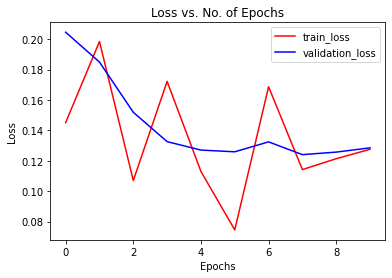

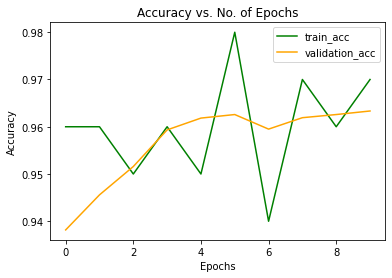

In [32]:

plot_loss(train_losses, val_losses)
plot_acc(train_metrics, val_metrics)